In [3]:
# !pip install casadi
# !pip install control

In [2]:
from __future__ import annotations        # can be used in Python 3.7 or higher
import numpy as np
import casadi as ca
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D
import matplotlib.animation as animation
import sys
sys.path.insert(0,'../test_system/quadrotor')
import params as par
import control

In [3]:
def thrust(throttle, rho, r, V, kV, CT, Cm):
    """
    throttle: 0-1 controls voltage
    rho: density of air, [kg/m^3]
    r: radius of propeller, [m]
    V: voltage of battery [V]
    kV: motor kV constant, [rpm/V]
    """
    omega = throttle*V*kV*(2*ca.pi/60)
    q = 0.5*rho*(omega*r)**2
    s = ca.pi*r**2

    return CT*q*s,Cm*q*s


def throttle(force, rho, r, V, kV, CT, Cm):
    s = ca.pi*r**2
    q = 0.25*force / (s * CT)
    omega = ((2*q/rho)**0.5)*(1/r)

    return (omega/(V*kV))*(60/(2*ca.pi))

def euler_kinematics(e, w):
    '''Derivative of Euler angles'''
    v = ca.SX.sym('v',3)
    v[2] = (w[1]*ca.sin(e[2])+w[2]*ca.cos(e[2]))/ca.cos(e[1])
    v[1] = w[1]*ca.cos(e[2]) - w[2]*ca.sin(e[2])
    v[0] = w[0] + (w[1]*ca.sin(e[2]+w[2]*ca.cos(e[2])))*ca.tan(e[1])
    return v

def rk4(f, t, y, h):
    """Runge Kuta 4th order integrator"""
    k1 = h * f(t, y)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h / 2, y + k2 / 2)
    k4 = h * f(t + h, y + k3)
    return ca.simplify(y + (k1 + 2 * k2 + 2 * k3 + k4) / 6)

def euler_to_dcm(e):
    ''' Transition from Euler angles to direction cosine matrix'''
    phi = e[0]
    theta = e[1]
    psi = e[2]
    R_z = np.array([
        [ca.cos(psi), -ca.sin(psi), 0],
        [ca.sin(psi), ca.cos(psi), 0],
        [0, 0, 1]
    ])
    R_y = np.array([
        [ca.cos(theta), 0, ca.sin(theta)],
        [0, 1, 0],
        [-ca.sin(theta), 0, ca.cos(theta)]
    ])
    R_x = np.array([
        [1, 0, 0],
        [0, ca.cos(phi), -ca.sin(phi)],
        [0, ca.sin(phi), ca.cos(phi)]
    ])

    R = np.dot(np.dot(R_z, R_y), R_x)
#     R = np.dot(R_x,np.dot(R_y, R_z))
    
    return R

def motor2mix(u_motor):
    '''from each motor duty to effect toward control angles'''
    map = np.array([
        [1,-1,-1,1],
        [-1,1,-1,1],
        [-1,-1,1,1],
        [1,1,1,1]])
    return ca.mtimes(map,u_motor)

def mix2motor(u_mix):
    '''from input of control to each motor duty'''
    map = np.linalg.inv(np.array([
        [1,-1,-1,1],
        [-1,1,-1,1],
        [-1,-1,1,1],
        [1,1,1,1]]))
    return ca.mtimes(map,u_mix)

def saturate(motor: ca.SX, len: int) -> ca.SX:
    ''' saturate the input motor voltage '''
    for i in range(4):
        temp = motor[i]
        temp = ca.if_else(temp > 1, 1,
                          ca.if_else(temp < 0, 0, temp))
        motor[i] = temp
    return motor

def update_lines(num, data, line):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(data[0:2, :num])
    line.set_3d_properties(data[2, :num])
    return line

In [4]:
def derive_equations():
    # Parameters & rotorcraft data
    arm_angles_deg = [45, -135, -45, 135]
    arm_angles_rad = [
        (np.pi / 180) * i for i in arm_angles_deg
    ]
    motor_dirs = [1, 1, -1, -1]             # motor rotation direction
    # # l_arm = 0.5                             # length or the rotor arm [m]
    # # m = 1                                   # mass of vehicle [kg]
    # rho = 1.225                             # density of air [kg/m^3]
    # # r = 0.05                                # radius of propeller
    # V = 11.1                                # voltage of battery [V]
    # kV = 1550                               # motor kV constant, [rpm/V]
    # CT = 1.0e-2                             # Thrust coeff
    # Cm = 1e-4                               # moment coeff
    # g = 9.81                                # gravitational constant [m/s^2]
    # # CT = 2.7e-4, Cm = 5e-5, r = 0.1778/2 other option

    # state (x)
    x = ca.SX.sym('x',12)
    omega_b = x[0:3]                      # Angular velocity (body)
    vel_b = x[3:6]                        # Velocity (body)
    euler = x[6:9]                        # Orientation (inertial) = r_nb
    pos_n = x[9:12]                       # Position (inertial)


    # input
    n_motors = len(arm_angles_deg)
    u_mix = ca.SX.sym('u_mix', 4)           # roll, pitch, yaw, throttle [V]

    # parameters
    p = ca.SX.sym('p', 12)
    m = p[0]                # mass of the body [kg]
    l_arm = p[1]            # length or the rotor arm [m]
    r = p[2]                # radius of propeller [m]
    rho = p[3]              # density of air [kg/m^3]
    V = p[4]                # voltage of battery [V]
    kV = p[5]               # motor kV constant, [rpm/V]
    CT = p[6]               # Thrust coeff
    Cm = p[7]               # moment coeff
    g = p[8]                # gravitational constant [m/s^2]
    Jx = p[9]
    Jy = p[10]
    Jz = p[11]


    J_b = ca.diag(ca.vertcat(Jx, Jy, Jz))                                             # Moment of inertia of quadrotor

    # forces and moments
    C_bn = euler_to_dcm(euler)                                                      # from euler to direction cosine matrix
    F_b = ca.vertcat(0, 0, 0)
    F_b = ca.mtimes(C_bn.T, ca.vertcat(0, 0, -m*g))                                  # Body Force Initialize  
    M_b = ca.SX.zeros(3)                                                            # Body moment(torque) Initialize
    u_motor = saturate(mix2motor(u_mix), len(motor_dirs))                           # convert u_mix(angle input) to motor duty

    for i in range(n_motors):
        ri_b = ca.vertcat(
            l_arm*ca.cos(arm_angles_rad[i]),
            l_arm*ca.sin(arm_angles_rad[i]), 
            0
        )                                                                           # vector to each motor from center
        Fi_b, Mi_b = thrust(
            throttle = u_motor[i], rho = rho, r = r,
            V = V, kV = kV, CT = CT, Cm = Cm                                        # get scalar F and M of each rotor
        )                                     
        Fi_b_vec = ca.vertcat(0, 0, Fi_b)
        Mi_b_vec = ca.vertcat(0, 0, motor_dirs[i] * Mi_b)                           # get each rotor's F and M vector
        F_b += Fi_b_vec                                                             # sum up all rotor F vector
        M_b += Mi_b_vec + ca.cross(ri_b, Fi_b_vec)                                  # sum up all rotor M vector & M from each leg

    rhs = ca.Function('rhs',[x,u_mix,p],[ca.vertcat(
        ca.mtimes(ca.inv(J_b),
                  M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))),                # omega dot (angular acceleration)
        F_b/m - ca.cross(omega_b,vel_b),                                            # v dot (acceleration)
        euler_kinematics(euler,omega_b),                                            # omega (angular velocity) (inertial)
        ca.mtimes(C_bn, vel_b),                                                     # v (velocity) (inertial)
        )], ['x','u_mix','p'],['x_dot'])

    # ref_traj = par.ref_trajectory
    # pos_diff = ref_traj - pos_n
    # vel_ref = pose_diff
    # k_vel = 
    # vel_cmd = k_vel*(vel_ref - ca.mtimes(C_bn, vel_b))
    # F_b = 

    # # prelim controller
    # roll_cmd = 0.2
    # pitch_cmd = 0.2
    # yaw_cmd = 0.2

    # u_control[0] = roll_mix
    # u_control[1] = pitch_mix
    # u_control[2] = yaw_mix
    # u_control[3] = 0.515
    # control = ca.Function('control', [x, p], [u_control], ['x', 'p'], ['u'])

    # rhs = ca.Function('rhs', [x, u, p], [x_dot], ['x', 'u', 'p'], ['x_dot'])
    # shadow_if_necessary = ca.Function('shadow_if_necessary', [r_nb], [so3.Mrp.shadow_if_necessary(r_nb)], ['r_nb'], ['r2_nb'])
    
    # mrp_to_euler = ca.Function('mrp_to_euler', [r_nb], [so3.Euler.from_mrp(r_nb)], ['r_nb'], ['euler'])
    
    # x_sat = ca.SX(x)
    # for i in range(4):
    #     v = x_sat[i + 13]
    #     v = ca.if_else(v > 1, 1, ca.if_else(v < 0, 0, v))
    #     x_sat[i + 13] = v
    # # saturate = ca.Function('saturate', [x], [x_sat], ['x'], ['x_sat'])

    return {
        'x': x,
        'u_mix': u_mix,
        'p': p,
        'rhs': rhs
    }

In [6]:
def objective(eqs, x_vect, u_vect, p):
    return ca.dot(u_vect, u_vect)

def constraint(eqs, x_vect, u_vect, p):
    uf = u_vect[-1]
    xf = x_vect[:, -1]
    #x_dot = eqs['rhs'](xf, uf, p)
    distance = np.linalg.norm(xf[9:12]-par.endpoint)
    C_bn = euler_to_dcm(xf[6:9])
    velocity = np.linalg.norm(ca.mtimes(C_bn,xf[3:6]))
    return ca.vertcat(
        distance,  # be at 10 m altitude
        velocity,  # don't change altitude
    )
    
def optimize_trajectory(eqs, x0, p, t0, tf, h):
    # symbolic integration
    x = x0
    
    t_vect = par.time
    n = len(t_vect)
    u_vect = ca.SX.sym('u', n,4)
    x_vect = x0

    for t, u in zip(t_vect, ca.vertsplit(u_vect,1)):
        res = scipy.integrate.solve_ivp(
            fun=lambda t, x: np.array(eqs['rhs'](x, u, p)).reshape(-1),
            t_span=[t, t+h], t_eval=[t+h], y0=xi
        )
        x = res['y']
        # x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        x_vect = ca.horzcat(x_vect, x)
    # NLP declaration
    nlp = {'x':u_vect,'f':objective(eqs, x, u_vect, p),'g':constraint(eqs, x_vect , u_vect, p)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    n_g = 1
    res = S(x0=np.zeros(n),
            lbg=np.zeros(n_g), ubg=np.zeros(n_g),
            lbx=-10*np.ones(n), ubx=10*np.ones(n)
           )
    stats = S.stats()
    print(stats['return_status'])
    u_opt = res['x']
    return t_vect, u_opt, x

def simulate(eqs, x0, p, t_vect, u_vect):
    data = {
        't': [t_vect[0]],
        'x': [np.reshape(x0, -1)],
        'u': [u_vect[0]]
    }
    x = x0
    h = t_vect[1] - t_vect[0] # assumes equally spaced
    for t, u in zip(t_vect, u_vect):
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        data['t'].append(t)
        data['u'].append(u)
        data['x'].append(np.reshape(x, -1))
    for k in data.keys():
        data[k] = np.array(data[k], dtype=float)
    return data

p = par.p
eqs = derive_equations()
x0 = [0] * 12
x0[9:12] = par.startpoint

t_vect, u_opt, x = optimize_trajectory(eqs, x0=x0, p=p, t0=0, tf=par.arrive_time, h=0.1)
data = simulate(eqs, x0, p, t_vect, u_opt)

plt.figure()
plt.plot(data['t'], data['x'][:, ], label='x')
plt.plot(data['t'], data['x'][:, 1], label='z')
plt.plot(data['t'], data['u'], label='omega')
plt.xlabel('t, sec')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(data['x'][:, 0], data['x'][:, 1])
plt.xlabel('x')
plt.ylabel('z')
plt.grid(True)
plt.title('trajectory [side]')


SystemError: <built-in function simplify> returned a result with an error set

In [16]:
def simulate(eqs: dict, dt: float, tf: float):
    x0 = [0]*12
    l_arm = 0.4                             # length or the rotor arm [m]
    m = 1                                # mass of vehicle [kg]
    rho = 1.225                             # density of air [kg/m^3]
    r = 0.1                                 # radius of propeller
    V = 11.1                                # voltage of battery [V]
    kV = 1550                               # motor kV constant, [rpm/V]
    CT = 1.0e-2                             # Thrust coeff
    Cm = 1e-4                               # moment coeff
    g = 9.81                                # gravitational constant [m/s^2]
    Jx = 0.021                              # Moment of inertia Ixx [kg*m^2]
    Jy = 0.021                              # Moment of inertia Iyy [kg*m^2]
    Jz = 0.042                              # Moment of inertia Izz [kg*m^2]
    p = [m, l_arm, r, rho, V, kV, CT, Cm, g, Jx, Jy, Jz]
    u0 = [0.0001,0.00,0.00,4]
    t_vect = np.arange(0, tf, dt)
    xi = x0
    data = {
        't': [],
        'x': [],
        'u': [],
        # 'euler': [],
    }
    for t in t_vect:
        # u = np.array(eqs['control'](xi, p0)).reshape(-1)

        data['x'].append(xi)
        data['u'].append(u0)
        data['t'].append(t)
        # data['euler'].append(np.array(eqs['mrp_to_euler'](xi[6:10])).reshape(-1))
        
        res = scipy.integrate.solve_ivp(
            fun=lambda t, x: np.array(eqs['rhs'](xi, u0, p)).reshape(-1),
             t_span=[t, t+dt], t_eval=[t+dt], y0=xi
        )
        xi_new = res['y']
        if xi_new[11] <= 0:
            xi_new[11] = 0
        xi = np.array(xi_new).reshape(-1)

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

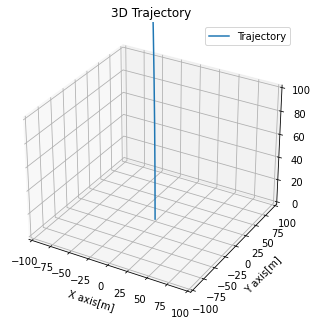

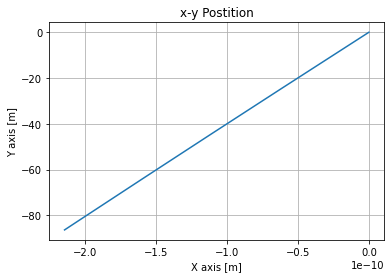

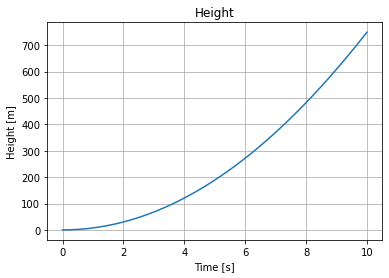

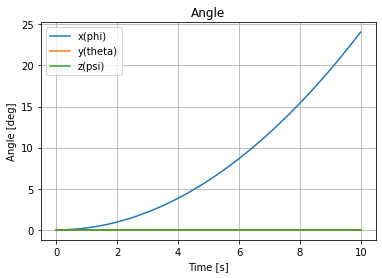

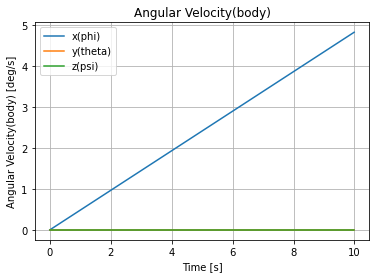

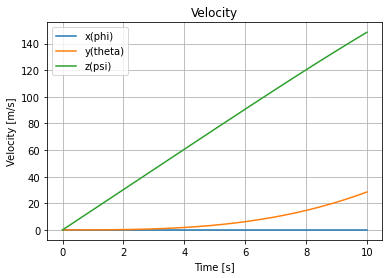

In [17]:
if __name__ == "__main__":
    quad_model = derive_equations()
    data = simulate(quad_model, 0.01, 10)

    fig1 = plt.figure(1)
    ax = Axes3D(fig1)
    ax.set_xlim3d(-100,100)
    ax.set_ylim3d(-100,100)
    ax.set_zlim3d(0,100)
    plt.plot(data['x'][:,9],
             data['x'][:,10],
             data['x'][:,11])
    plt.title('3D Trajectory')
    plt.xlabel('X axis[m]')
    plt.ylabel('Y axis[m]')
    plt.legend(['Trajectory'])
    plt.grid()

    fig2 = plt.figure(2)
    plt.plot(data['x'][:,9],
              data['x'][:,10],)
    plt.title('x-y Postition')
    plt.xlabel('X axis [m]')
    plt.ylabel('Y axis [m]')
    plt.grid()
    
    fig3 = plt.figure(3)
    plt.plot(data['t'],data['x'][:,11])
    plt.title('Height')
    plt.xlabel('Time [s]')
    plt.ylabel('Height [m]')
    plt.grid()
    
    fig3 = plt.figure(4)
    plt.plot(data['t'], data['x'][:,6]*180/ca.pi,
             data['t'], data['x'][:,7]*180/ca.pi,
             data['t'], data['x'][:,8]*180/ca.pi)
    plt.title('Angle')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle [deg]')
    plt.legend(['x(phi)','y(theta)','z(psi)'])
    plt.grid()
    
    plt.figure(5)
    plt.plot(data['t'], data['x'][:,0]*180/ca.pi,
             data['t'], data['x'][:,1]*180/ca.pi,
             data['t'], data['x'][:,2]*180/ca.pi)
    plt.title('Angular Velocity(body)')
    plt.xlabel('Time [s]')
    plt.ylabel('Angular Velocity(body) [deg/s]')
    plt.legend(['x(phi)','y(theta)','z(psi)'])
    plt.grid()

    plt.figure(6)
    plt.plot(data['t'], data['x'][:,3],
             data['t'], data['x'][:,4],
             data['t'], data['x'][:,5])
    plt.title('Velocity')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [m/s]')
    plt.legend(['x(phi)','y(theta)','z(psi)'])
    plt.grid()

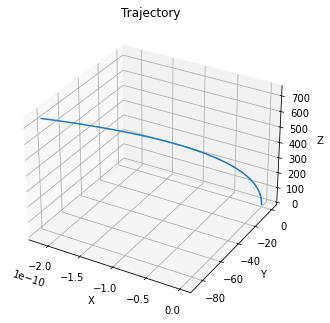

In [18]:
    # Attaching 3D axis to the figure
    fig3 = plt.figure(num = 3, figsize=(plt.figaspect(1)))
    ax = Axes3D(fig3)

    x = data['x'][:,9]
    y = data['x'][:,10]
    z = data['x'][:,11]
    data_plot = np.array([x,y,z])

    line = ax.plot(x, y, z)[0]

    

    # Setting the axes properties
    # ax.set_xlim3d([-50, 50])
    # ax.set_ylim3d([-50, 50])
    # ax.set_zlim3d([0, 100])

    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    ax.set_zlabel('Z')

    ax.set_title('Trajectory')

    # Creating the Animation object
    line_ani = animation.FuncAnimation(fig3, update_lines, frames = x.size, fargs=(data_plot, line),
                                interval=50, blit=False)
    line_ani.save('./flight.gif', writer='pillow', fps=60)

    plt.show()

In [7]:
def linearize():
    eqs = derive_equations()
    x = eqs['x']
    u_mix = eqs['u_mix']
    p = eqs['p']
    y = x  # state feedback
    rhs = eqs['rhs']
    xdot = rhs(x, u_mix, p)
    A = ca.jacobian(xdot, x)
    B = ca.jacobian(xdot, u_mix)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u_mix)
    return ca.Function('ss', [x, u_mix, p], [A, B, C, D],
            ['x', 'u', 'p'], ['A', 'B', 'C', 'D'])